# Linear Classification and Regression
## When Logistic Regression Is Good and When It Is Not

## Analysis of IMDB movie reviews

We want to solve the problem of binary classification of IMDB movie reviews. We have a training set with marked reviews, 12500 reviews marked as good, another 12500 bad. Here, it’s not easy to get started with machine learning right away because we don’t have the matrix X; we need to prepare it. We will use a simple approach: bag of words model. Features of the review will be represented by indicators of the presence of each word from the whole corpus in this review. The corpus is the set of all user reviews. The idea is illustrated by a picture

![img](https://mlcourse.ai/_images/topic4_bag_of_words.svg)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
#sharper plots
%config InlineBackend.figure_format = 'retina'
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:


url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


def load_imdb_dataset(extract_path, overwrite=False):
    
    import tarfile
    from io import BytesIO
    import requests
    
    # check if existed already
    if (
        os.path.isfile(os.path.join(extract_path, "aclImdb", "README"))
        and not overwrite
    ):
        print("IMDB dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    tar = tarfile.open(mode="r:gz", fileobj=BytesIO(response.content))

    data = tar.extractall(extract_path)

In [3]:
DATA_PATH = "../../data/"

load_imdb_dataset(extract_path=DATA_PATH, overwrite=True)

In [4]:
PATH_TO_IMDB = DATA_PATH + "aclImdb"

reviews_train = load_files(
    os.path.join(PATH_TO_IMDB, "train"), categories=["pos", "neg"]
)
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=["pos", "neg"])
text_test, y_test = reviews_test.data, reviews_test.target

In [5]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


**Here are a few examples of the reviews.**

In [8]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [9]:
y_train[1]  # bad review

0

In [10]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [11]:
y_train[2]  # good review

1

## A Simple Word Count

First, we will create a dictionary of all the words using CountVectorizer

In [12]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

In [13]:
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02'
 '020410' '029' '03' '04' '041' '05' '050' '06' '06th' '07' '08' '087'
 '089' '08th' '09' '0f' '0ne' '0r' '0s' '10' '100' '1000' '1000000'
 '10000000000000' '1000lb' '1000s' '1001' '100b' '100k' '100m']
['pincher' 'pinchers' 'pinches' 'pinching' 'pinchot' 'pinciotti' 'pine'
 'pineal' 'pineapple' 'pineapples' 'pines' 'pinet' 'pinetrees' 'pineyro'
 'pinfall' 'pinfold' 'ping' 'pingo' 'pinhead' 'pinheads' 'pinho' 'pining'
 'pinjar' 'pink' 'pinkerton' 'pinkett' 'pinkie' 'pinkins' 'pinkish'
 'pinko' 'pinks' 'pinku' 'pinkus' 'pinky' 'pinnacle' 'pinnacles' 'pinned'
 'pinning' 'pinnings' 'pinnochio' 'pinnocioesque' 'pino' 'pinocchio'
 'pinochet' 'pinochets' 'pinoy' 'pinpoint' 'pinpoints' 'pins' 'pinsent']


In [14]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

In [15]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [16]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [17]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

In [22]:
X_test = cv.transform(text_test)

In [18]:
%%time
logit = LogisticRegression(solver="lbfgs", n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 235 ms, sys: 238 ms, total: 474 ms
Wall time: 5.82 s


/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(n_jobs=-1, random_state=7)

In [23]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3)

(0.982, 0.864)

The coefficients of the model can be beautifully displayed

In [29]:
classifier = logit

In [31]:
coef = classifier.coef_.ravel()
coef

array([-0.11003349, -0.04468308, -0.00962268, ...,  0.00108741,
       -0.05299179, -0.01356696])

In [33]:
n_top_features=5
positive_coefficients = np.argsort(coef)[-n_top_features:]
positive_coefficients

array([64644, 53544, 26380, 54378, 73498])

In [34]:
negative_coefficients = np.argsort(coef)[:n_top_features]
negative_coefficients

array([72229, 18642, 50821, 37435, 42368])

In [35]:
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
interesting_coefficients

array([72229, 18642, 50821, 37435, 42368, 64644, 53544, 26380, 54378,
       73498])

In [24]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

In [25]:
def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend();

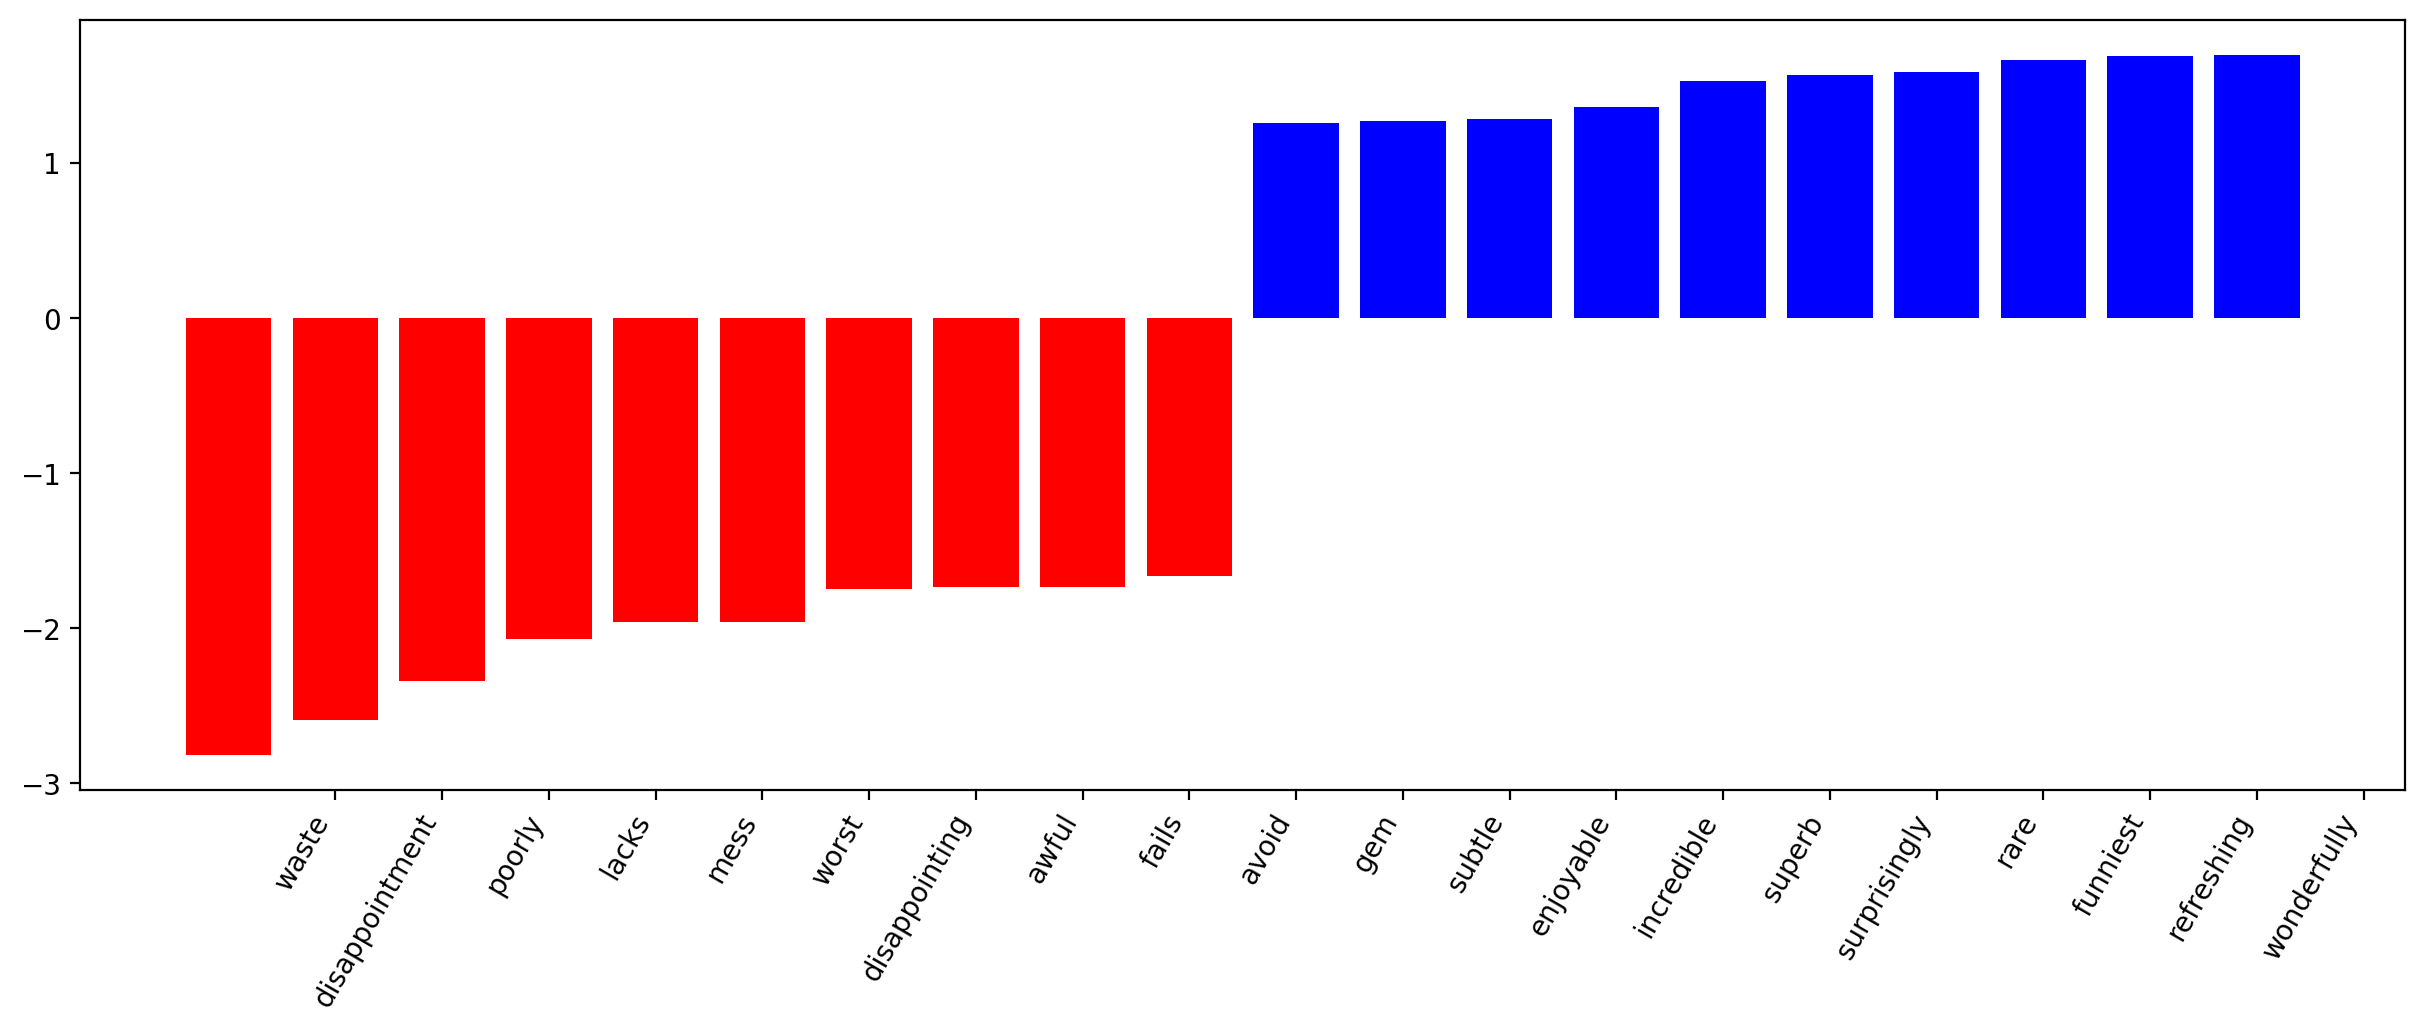

In [28]:
visualize_coefficients(logit, cv.get_feature_names_out(), n_top_features=10);

To make our model better, we can optimize the regularization coefficient for the Logistic Regression. We’ll use sklearn.pipeline because CountVectorizer should only be applied to the training data (so as to not “peek” into the test set and not count word frequencies there). In this case, pipeline determines the correct sequence of actions: apply CountVectorizer, then train Logistic Regression.

In [39]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(
    CountVectorizer(),
    # for some reason n_jobs > 1 won't work
    # with GridSearchCV's n_jobs > 1
    LogisticRegression(solver="lbfgs", n_jobs=1, random_state=7),
)

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.86432
CPU times: user 1min 36s, sys: 1.69 s, total: 1min 37s
Wall time: 21.7 s


In [40]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {"logisticregression__C": np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(
    text_pipe_logit, param_grid_logit, return_train_score=True, cv=3, n_jobs=-1
)

grid_logit.fit(text_train, y_train)

/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

CPU times: user 1min 51s, sys: 1.91 s, total: 1min 53s
Wall time: 1min 33s


/home/diego/miniconda3/envs/ds-min/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

In [41]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8855199324363663)

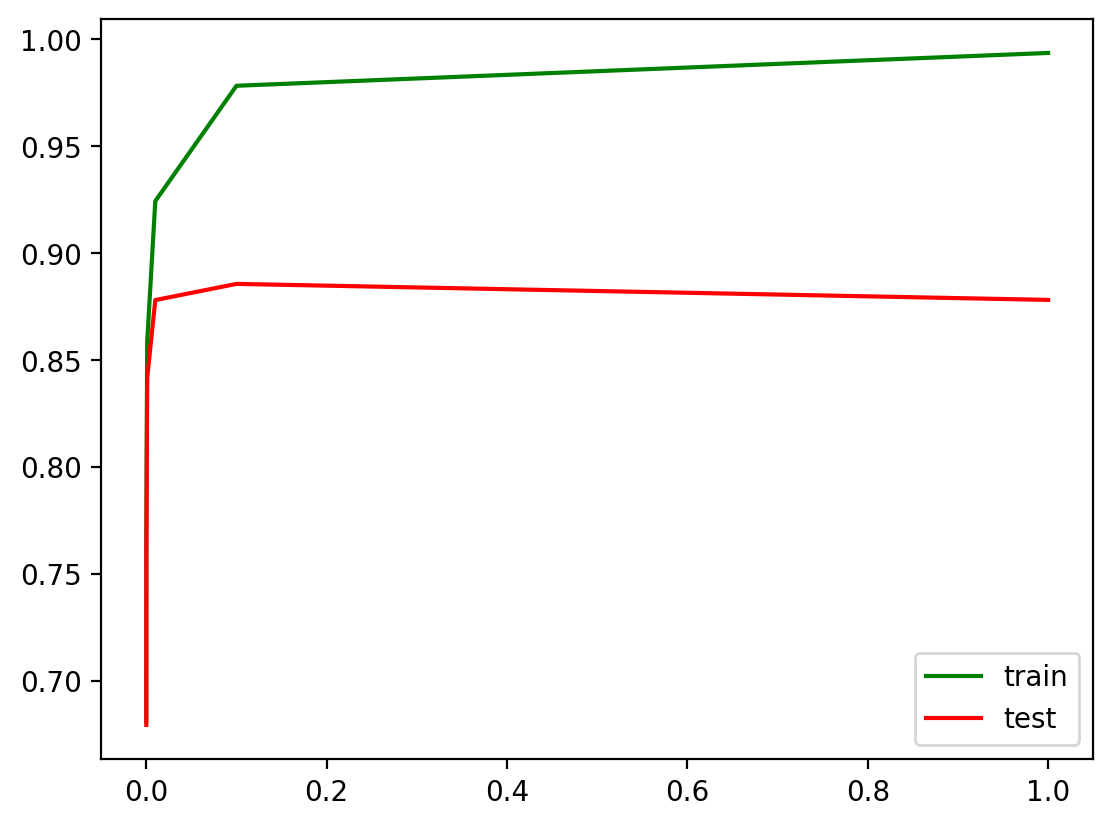

In [42]:
plot_grid_scores(grid_logit, "logisticregression__C")

Now let’s do the same with random forest. We see that, with logistic regression, we achieve better accuracy with less effort.

In [44]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

forest.fit(X_train, y_train)

CPU times: user 8min 22s, sys: 11.1 s, total: 8min 33s
Wall time: 1min 7s


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [45]:
round(forest.score(X_test, y_test), 3)

0.855

## The XOR Problem
Let’s now consider an example where linear models are worse.

Linear classification methods still define a very simple separating surface - a hyperplane. The most famous toy example of where classes cannot be divided by a hyperplane (or line) with no errors is “the XOR problem”.

XOR is the “exclusive OR”, a Boolean function with the following truth table:

![img](https://mlcourse.ai/_images/topic4_XOR_table.gif)

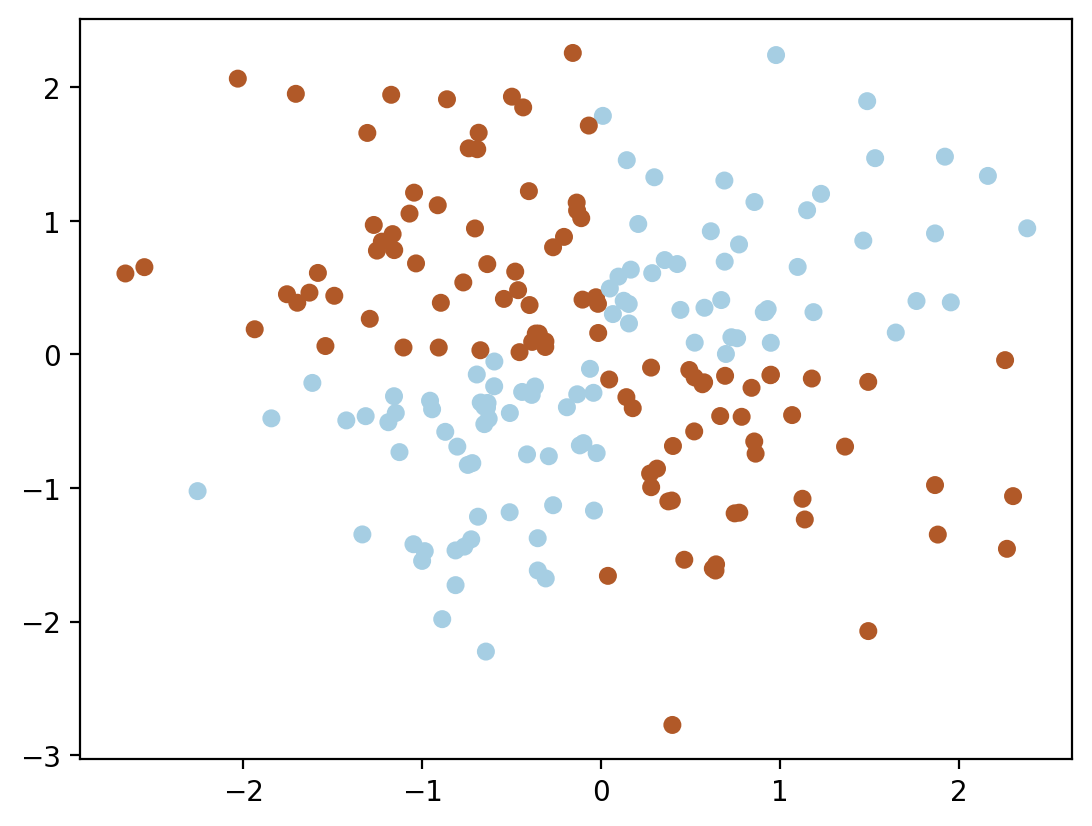

In [46]:
# creating dataset
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

Obviously, one cannot draw a single straight line to separate one class from another without errors. Therefore, logistic regression performs poorly with this task.

In [47]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.PuOr_r,
    )
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

/tmp/ipykernel_39947/3069517639.py:16: UserWarning: The following kwargs were not used by contour: 'linetypes'
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")


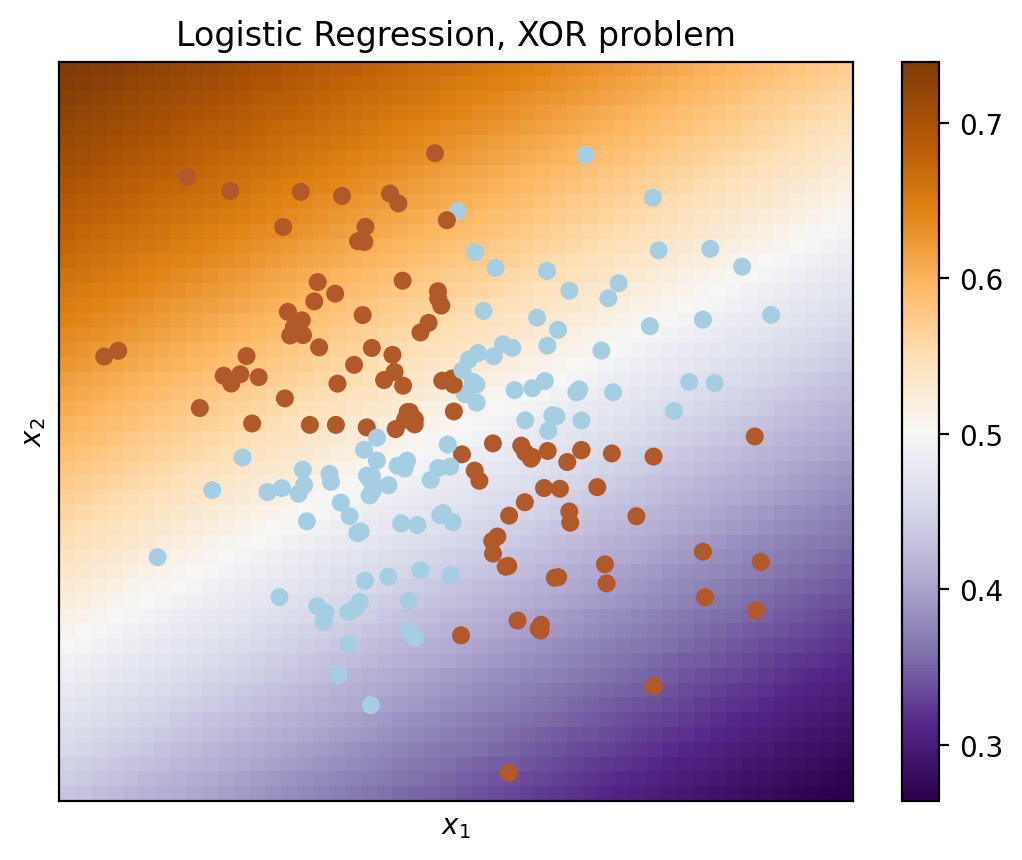

In [48]:
plot_boundary(
    LogisticRegression(solver="lbfgs"), X, y, "Logistic Regression, XOR problem"
)

But if one were to give polynomial features as an input (here, up to 2 degrees), then the problem is solved.

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

logit_pipe = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("logit", LogisticRegression(solver="lbfgs")),
    ]
)

/tmp/ipykernel_39947/3069517639.py:16: UserWarning: The following kwargs were not used by contour: 'linetypes'
  contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linetypes="--")


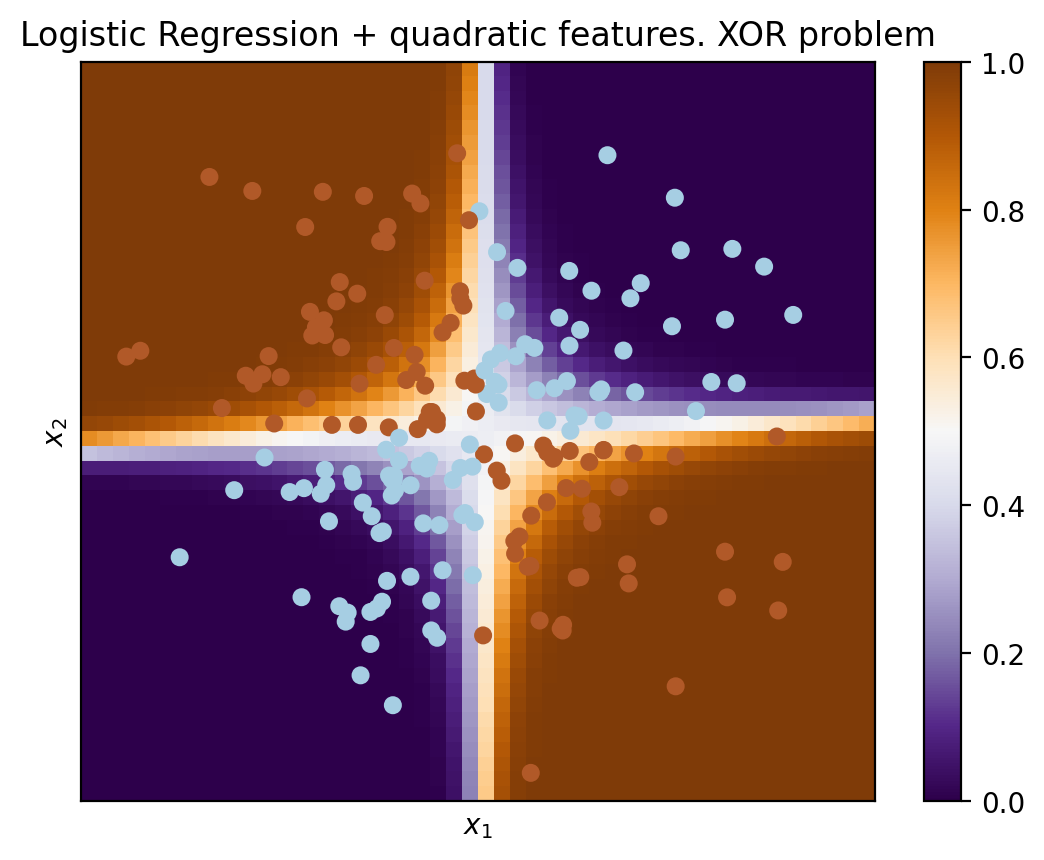

In [56]:
plot_boundary(logit_pipe, X, y, "Logistic Regression + quadratic features. XOR problem")

Here, logistic regression has still produced a hyperplane but in a 6-dimensional feature space 
$$
    1, x_1, x_2, x_1^2, x_1x_2, x_2^2
$$. When we project to the original feature space, $x_1, x_2$, the boundary is nonlinear.

In practice, polynomial features do help, but it is computationally inefficient to build them explicitly. SVM with the kernel trick works much faster. In this approach, only the distance between the objects (defined by the kernel function) in a high dimensional space is computed, and there is no need to produce a combinatorially large number of features.